In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd

print(tf.__version__)

2.8.2


#DATA PREPROCESSING

In [2]:
datasetpath="/content/drive/MyDrive/project/fundus/1000images"

In [3]:
filepaths = list(glob.glob(datasetpath+'/**/*.*'))

In [4]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

Filepath  \
0  /content/drive/MyDrive/project/fundus/1000imag...   
1  /content/drive/MyDrive/project/fundus/1000imag...   
2  /content/drive/MyDrive/project/fundus/1000imag...   
3  /content/drive/MyDrive/project/fundus/1000imag...   
4  /content/drive/MyDrive/project/fundus/1000imag...   

                                       Label  
0                  Yellow-white spots-flecks  
1                          Cotton-wool spots  
2                                        ERM  
3                       Retinitis pigmentosa  
4  Peripheral retinal degeneration and break

In [5]:
def high_resdata(df,size):
  high=[]
  for i in range(500):
    im=cv2.imread(df['Filepath'][i])
    im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im=cv2.resize(im,[size,size])
    im=im.astype(np.float32)/255.0
    high.append(img_to_array(im))
  return high
    

In [6]:
def low_resdata(df,size):
  low=[]
  for i in range(500):
    im=cv2.imread(df['Filepath'][i])
    im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im=cv2.resize(im,[size,size])
    im=cv2.resize(im,[size*4,size*4])
    im=im.astype(np.float32)/255.0
    low.append(img_to_array(im))
  return low


In [7]:
high_res=high_resdata(data,512)
low_res=low_resdata(data,128)



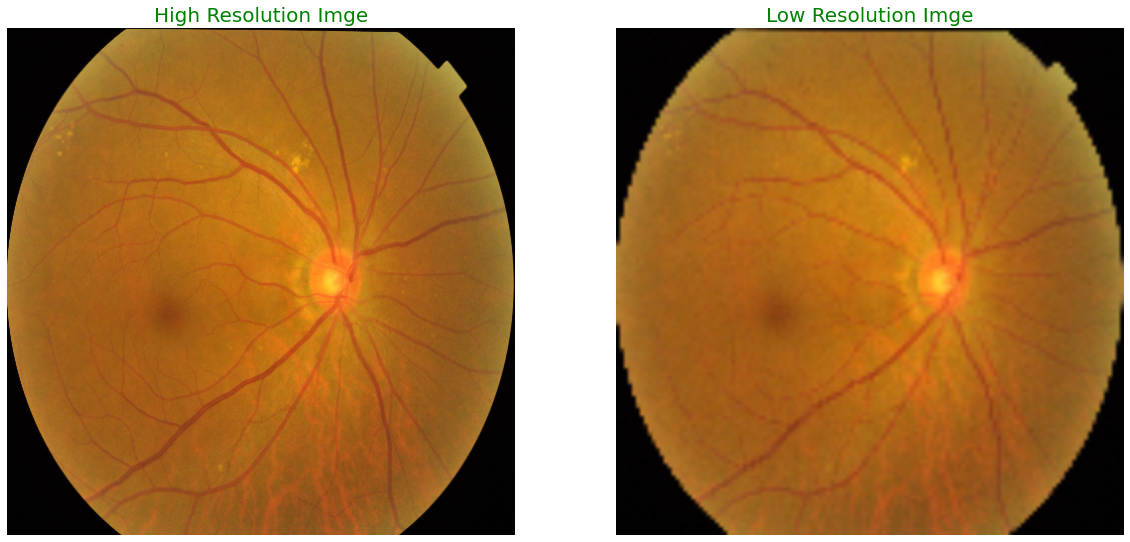

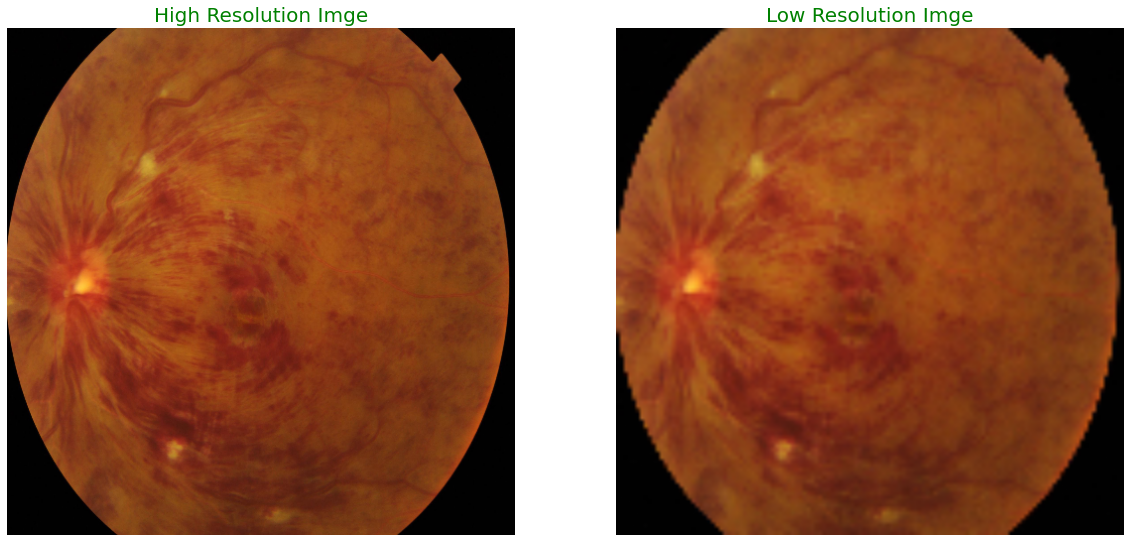

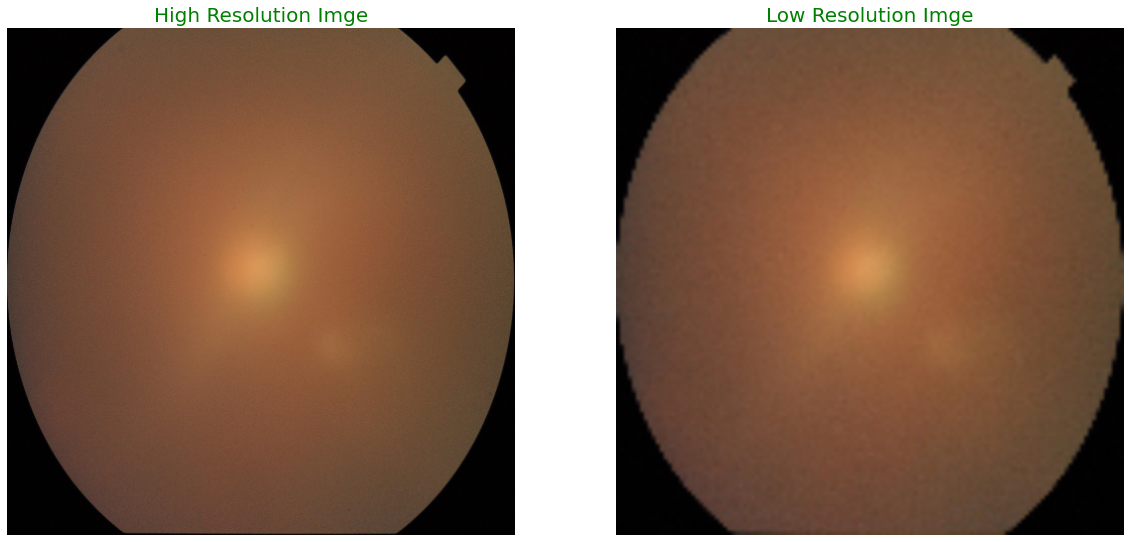

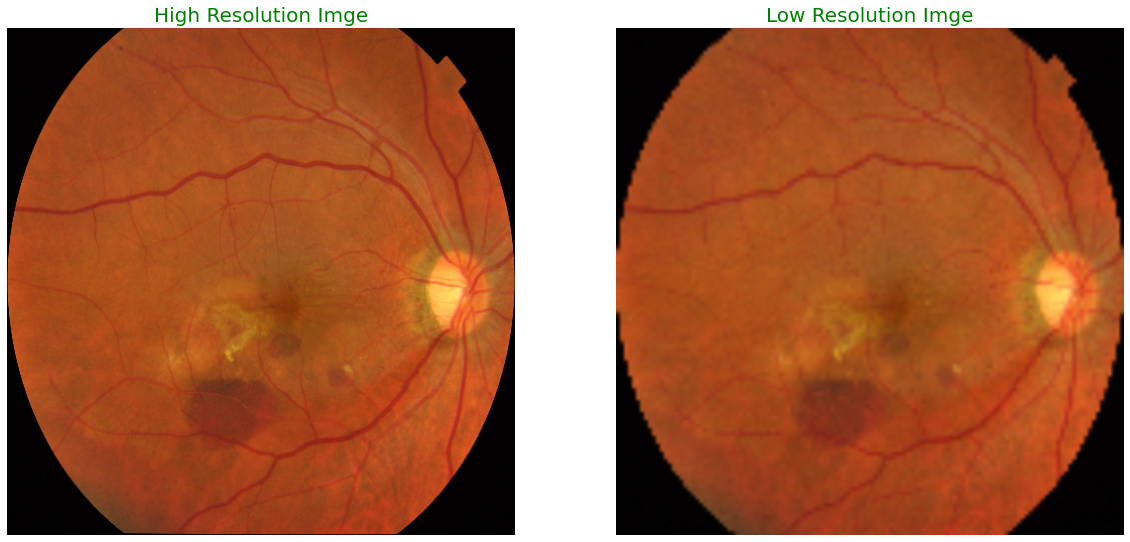

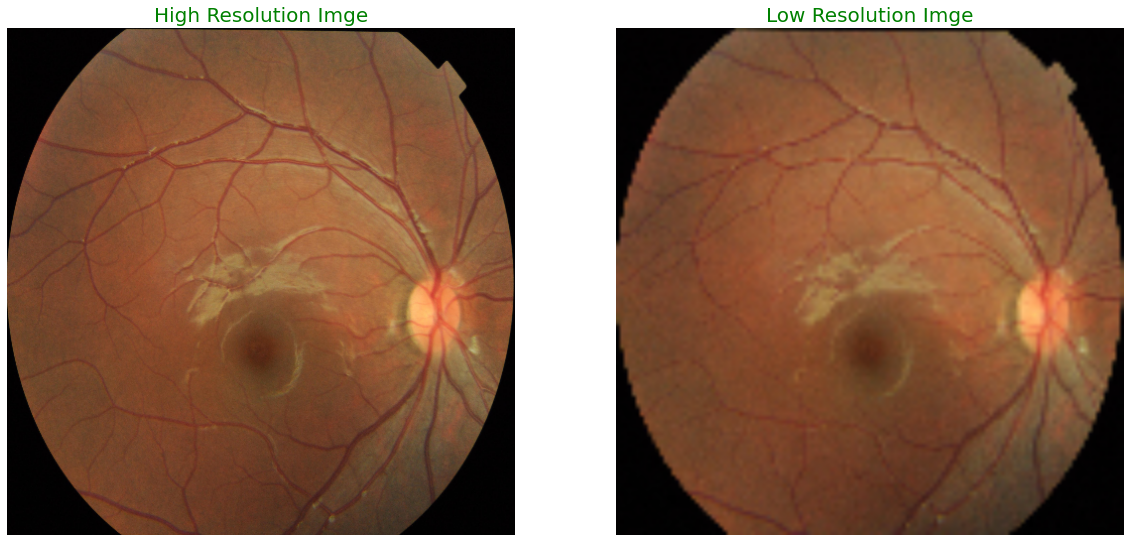

In [8]:
for i in range(5):
  a = np.random.randint(0,500)
  plt.figure(figsize=(20,20))
  plt.subplot(1,2,1)
  plt.title('High Resolution Imge', color = 'green', fontsize = 20)
  plt.imshow(high_res[a])
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.title('Low Resolution Imge', color = 'green', fontsize = 20)
  plt.imshow(low_res[a])
  plt.axis('off')


splitting the data

In [9]:
SIZE=512
high_res_train=high_res[:400]
low_res_train=low_res[:400]


high_res_train = np.reshape(high_res_train,(len(high_res_train),SIZE,SIZE,3))
low_res_train = np.reshape(low_res_train,(len(low_res_train),SIZE,SIZE,3))

high_res_valid=high_res[400:450]
low_res_valid=low_res[400:450]


high_res_valid= np.reshape(high_res_valid,(len(high_res_valid),SIZE,SIZE,3))
low_res_valid = np.reshape(low_res_valid,(len(low_res_valid),SIZE,SIZE,3))

high_res_test=high_res[450:]
low_res_test=low_res[450:]


high_res_test= np.reshape(high_res_test,(len(high_res_test),SIZE,SIZE,3))
low_res_test = np.reshape(low_res_test,(len(low_res_test),SIZE,SIZE,3))



print("Shape of training images:",high_res_train.shape)
print("Shape of test images:",high_res_test.shape)
print("Shape of validation images:",high_res_valid.shape)


Shape of training images: (400, 512, 512, 3)
Shape of test images: (50, 512, 512, 3)
Shape of validation images: (50, 512, 512, 3)


#MODEL BUILDING

In [10]:
SIZE=512

In [11]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    downsample.add(layers.Dropout(.2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    upsample.add(layers.Dropout(.2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [17]:
def model():
  inputs=layers.Input(shape=[SIZE,SIZE,3]) #512x512x3
  d1=down(128,(3,3),False)(inputs)         #256x256x128
  d2=down(256,(3,3),False)(d1)             #128x128x256
  d3=down(512,(3,3),True)(d2)             #64x64x512
  d4=down(1024,(3,3),True)(d3)            #32x32x1024
  d5=down(2048,(3,3),True)(d4)            #16x16x2048
  d6=down(2048,(3,3),True)(d5)            #8x8x2048
  u1=up(2048,(3,3),False)(d6)              #16x16x2048
  u1=layers.concatenate([u1,d5])           #16x16x4096
  u2=up(1024,(3,3),False)(u1)              #32x32x1024
  u2=layers.concatenate([u2,d4])           #32x32x2048
  u3=up(512,(3,3),False)(u2)               #64x64x512
  u3=layers.concatenate([u3,d3])           #64x64x1024
  u4=up(256,(3,3),False)(u3)               #128x128x256
  u4=layers.concatenate([u4,d2])           #128x128x512
  u5=up(128,(3,3),False)(u4)               #256x256x128
  u5=layers.concatenate([u5,d1])           #256x256x256
  u6=up(3,(3,3),False)(u5)                 #512x512x3
  u6=layers.concatenate([u6,inputs])           #512x512x6
  output=layers.Conv2D(3,(2,2),strides=1,padding='same')(u6) #512x512x3
  return tf.keras.Model(inputs=inputs, outputs=output)

In [18]:
model=model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_12 (Sequential)     (None, 256, 256, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_13 (Sequential)     (None, 128, 128, 25  295168      ['sequential_12[0][0]']          
                                6)                                                          

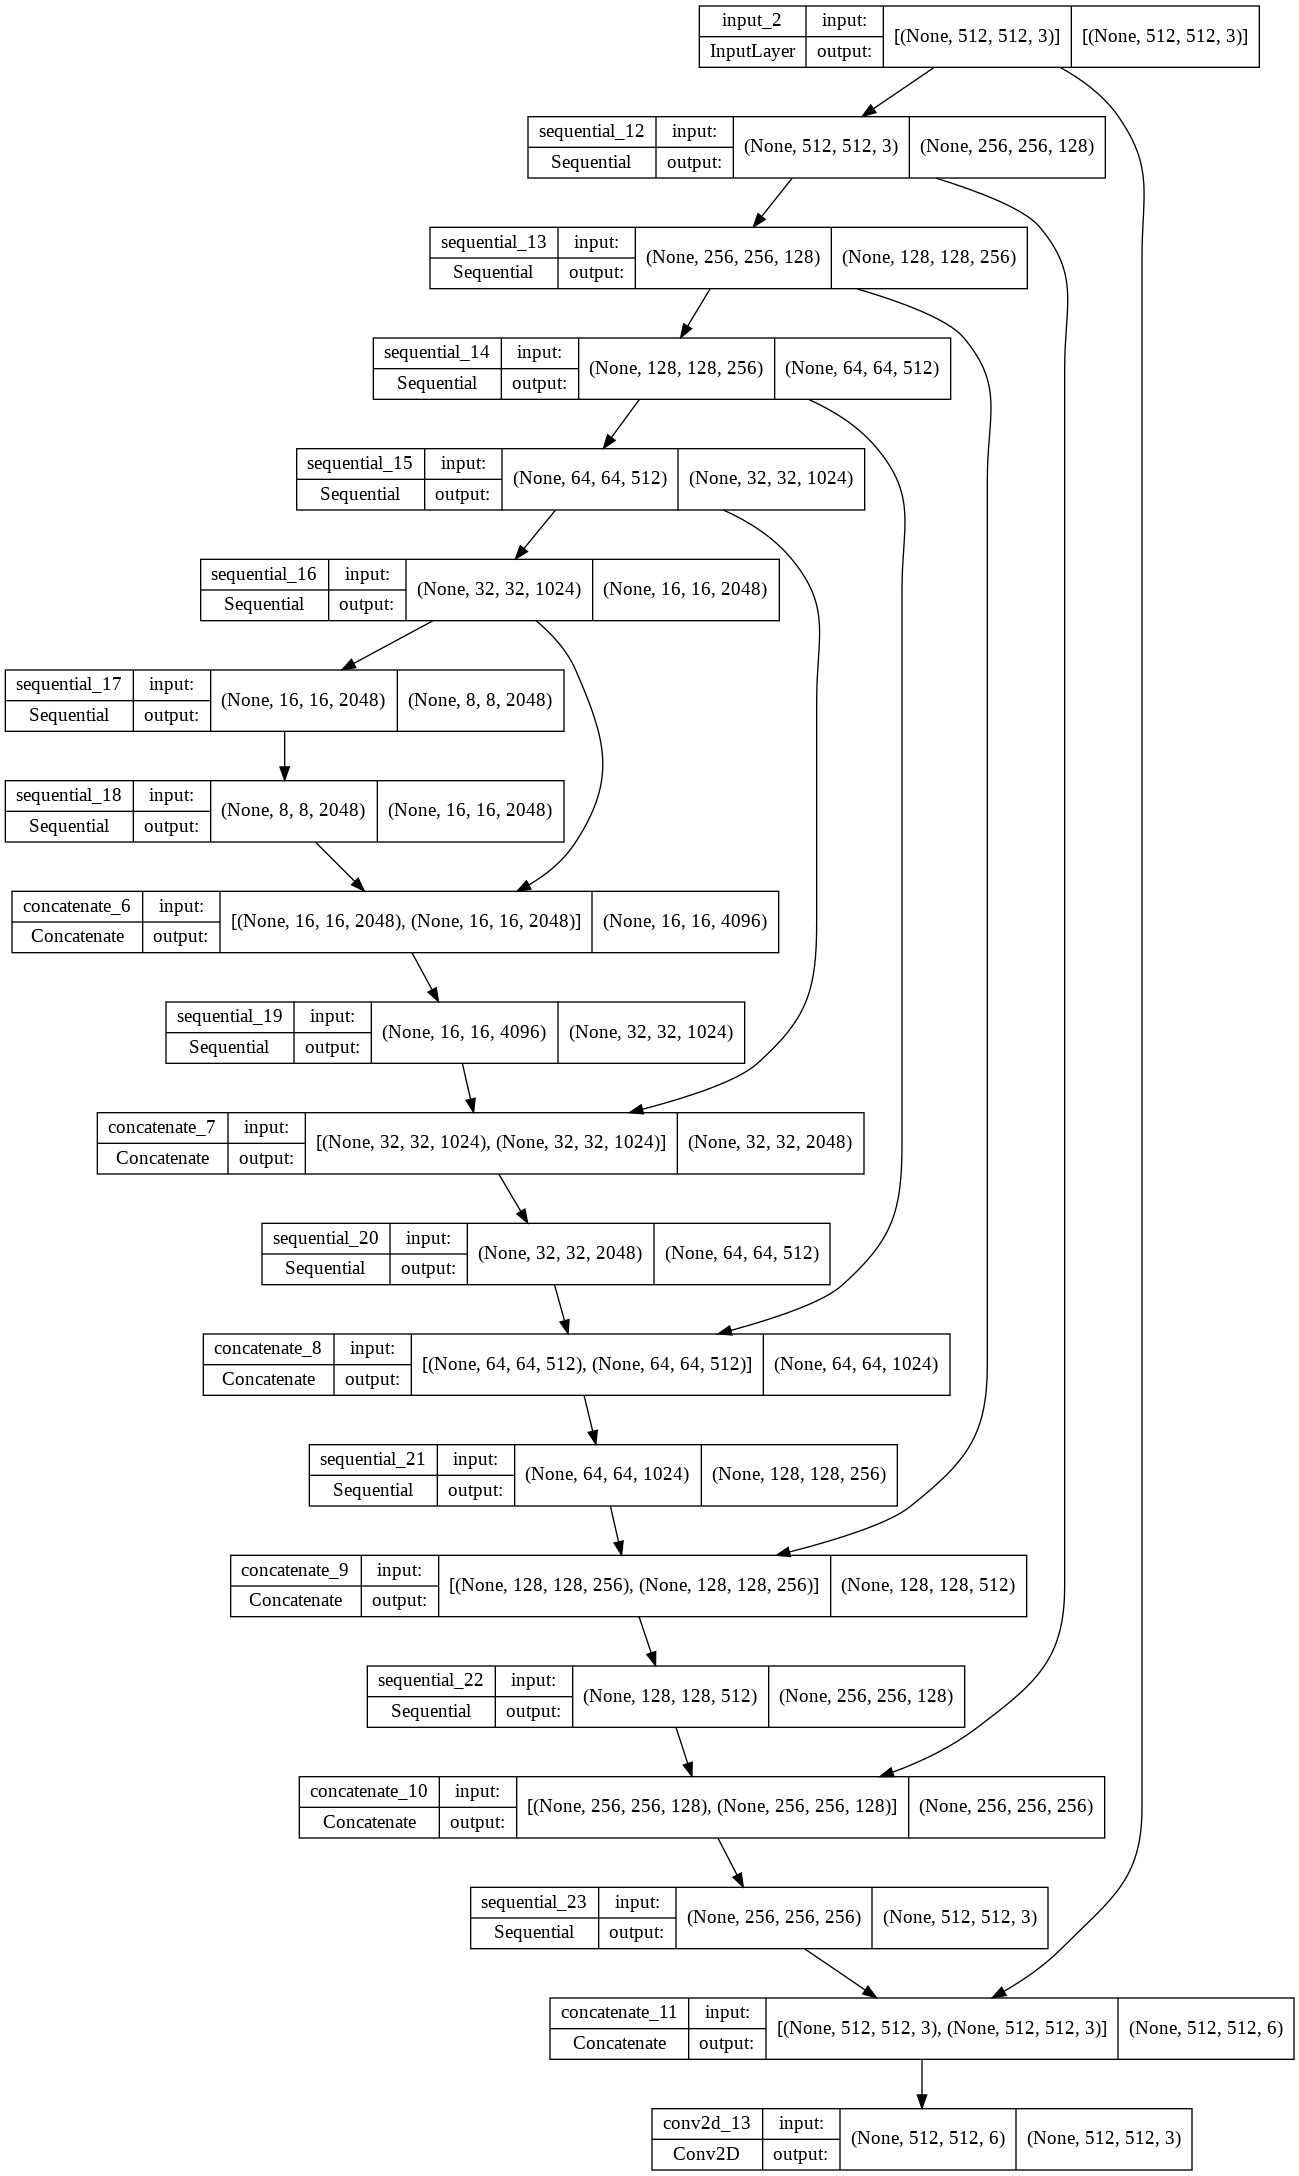

In [19]:
tf.keras.utils.plot_model(model, to_file="model1.png", show_shapes=True)

#MODEL TRAINING

In [20]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [21]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2)

In [22]:
history=model.fit(low_res_train, high_res_train, epochs = 50, batch_size = 1,
          validation_data = (low_res_valid,high_res_valid),callbacks=[es])

Epoch 1/50
400/400 [==============================] - 144s 308ms/step - loss: 0.0449 - acc: 0.8758 - val_loss: 0.0130 - val_acc: 0.9863
Epoch 2/50
400/400 [==============================] - 123s 307ms/step - loss: 0.0157 - acc: 0.9307 - val_loss: 0.0116 - val_acc: 0.9891
Epoch 3/50
400/400 [==============================] - 123s 307ms/step - loss: 0.0134 - acc: 0.9402 - val_loss: 0.0105 - val_acc: 0.9838
Epoch 4/50
400/400 [==============================] - 124s 309ms/step - loss: 0.0120 - acc: 0.9459 - val_loss: 0.0110 - val_acc: 0.9146
Epoch 5/50
400/400 [==============================] - 122s 306ms/step - loss: 0.0112 - acc: 0.9441 - val_loss: 0.0094 - val_acc: 0.9318
Epoch 6/50
400/400 [==============================] - 122s 306ms/step - loss: 0.0106 - acc: 0.9469 - val_loss: 0.0096 - val_acc: 0.9801
Epoch 7/50
400/400 [==============================] - 124s 309ms/step - loss: 0.0103 - acc: 0.9467 - val_loss: 0.0100 - val_acc: 0.9505
Epoch 7: early stopping


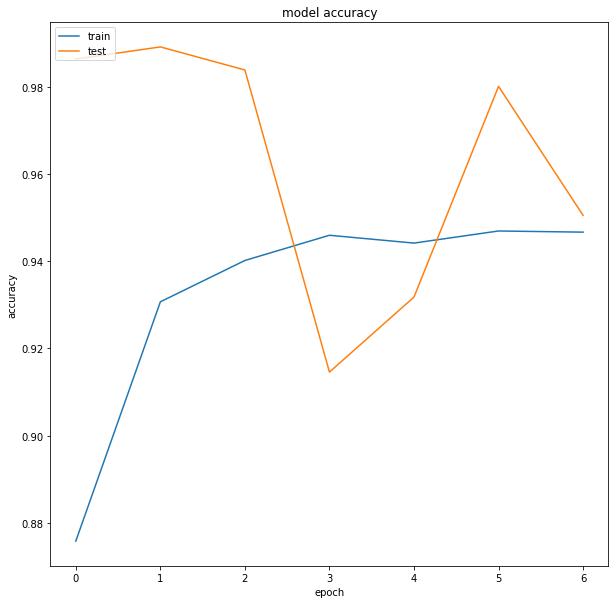

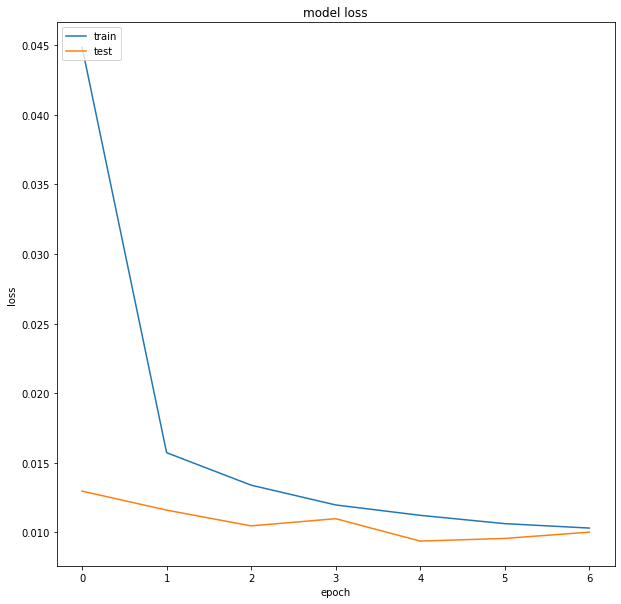

In [23]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('modelaccuracy.png')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show
plt.savefig('modelloss.png')

In [24]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def SSIM(low_res,high_res):
  return ssim(low_res,high_res,multichannel=True) 
def PSNR(y_true,y_pred):
  return psnr(y_true,y_pred) 

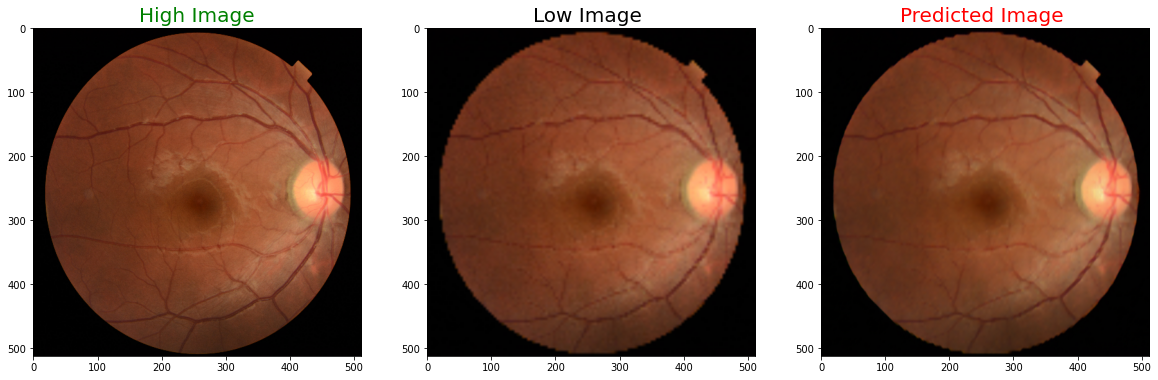

SSIM 0.9595721825419293
PSNR 34.78748093030849 dB


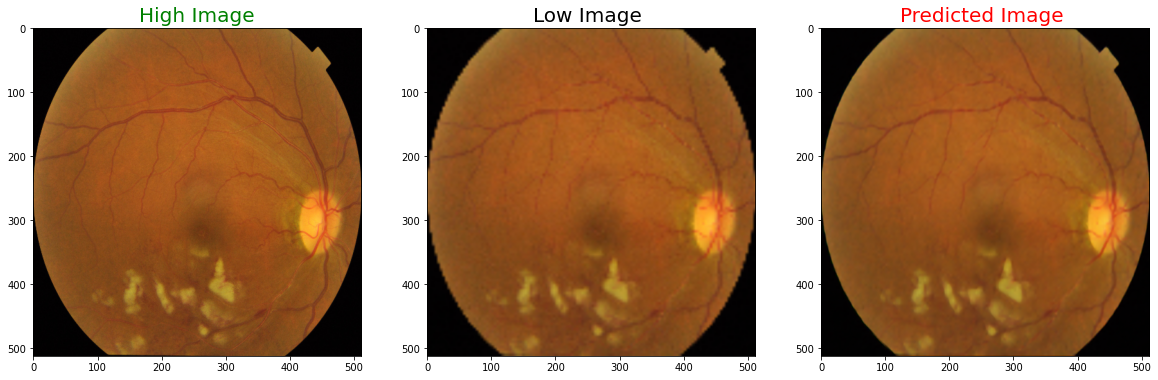

SSIM 0.9608733482241957
PSNR 34.52623044091824 dB


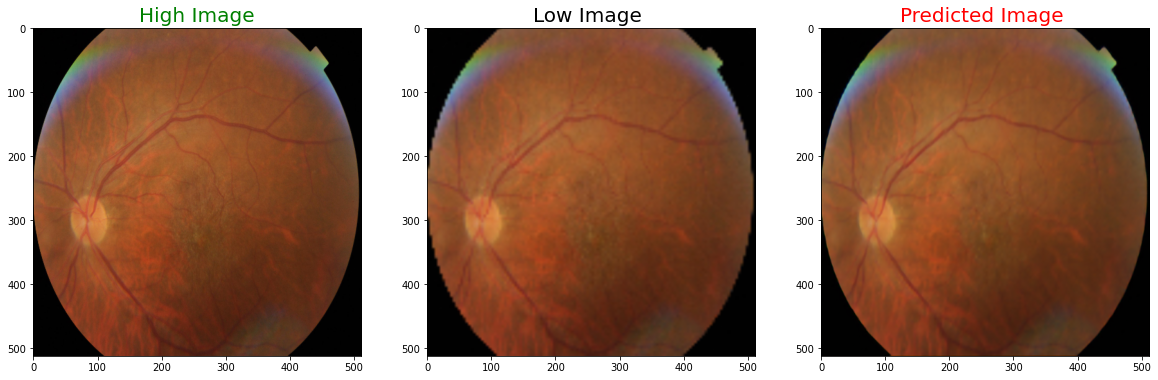

SSIM 0.9786507425477633
PSNR 37.10076060998058 dB


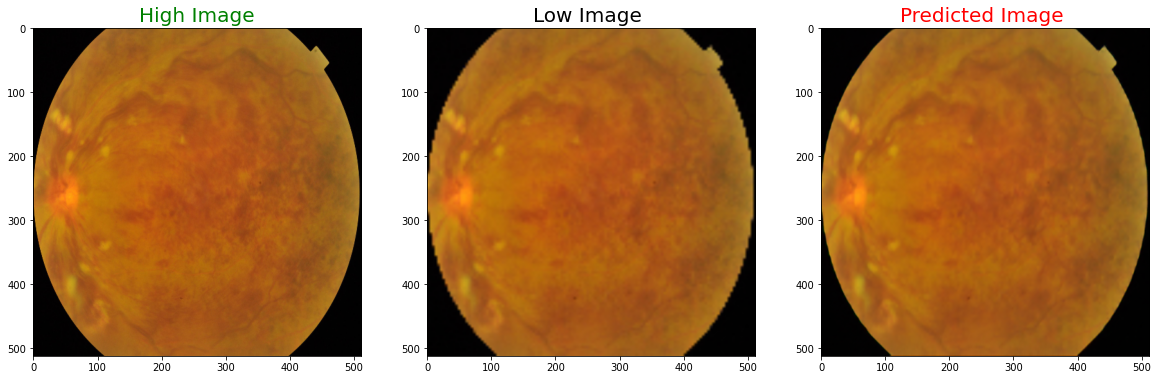

SSIM 0.9833838937179736
PSNR 36.82374058102402 dB


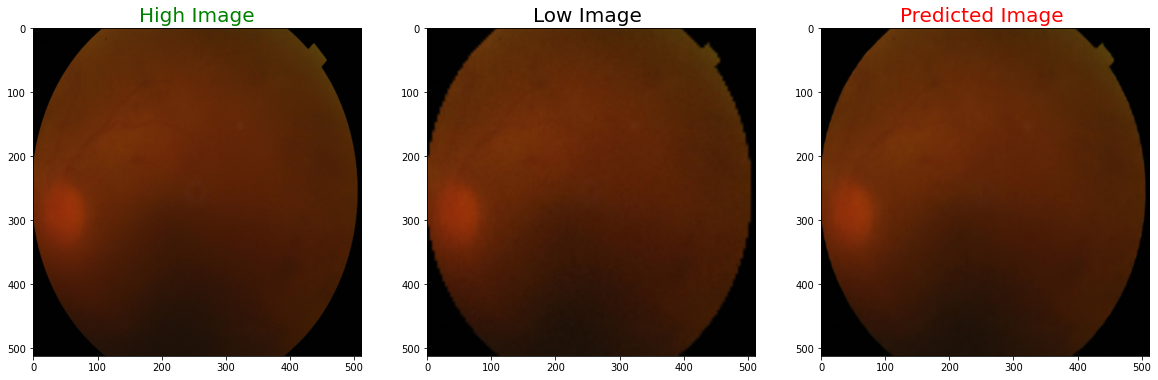

SSIM 0.9891044653404558
PSNR 42.16183867842321 dB


In [25]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(20,20)) 
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.savefig('pred'+str(i)+'.png') 
    plt.show()

for i in range(0,5):
    
    predicted = np.clip(model.predict(low_res_test[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(high_res_test[i],low_res_test[i],predicted)
    print('SSIM',SSIM(high_res_test[i],predicted))
    print('PSNR',PSNR(high_res_test[i],predicted),'dB')